<a href="https://colab.research.google.com/github/kazuhiro1999/Automatic-Evaluation-of-Dance-Movements/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

## preparetion

In [1]:
!git clone https://github.com/kazuhiro1999/Automatic-Evaluation-of-Dance-Movements.git
%cd Automatic-Evaluation-of-Dance-Movements

Cloning into 'Automatic-Evaluation-of-Dance-Movements'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 50 (delta 14), reused 37 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), 2.47 MiB | 5.26 MiB/s, done.
/content/Automatic-Evaluation-of-Dance-Movements


In [2]:
%mkdir data

import gdown
gdown.download('https://drive.google.com/uc?id=1DYGHbrxAEtDcVPCeM_oZyXNpEGZD4S8G', './data/keypoints.zip')
gdown.download('https://drive.google.com/uc?id=1HhCZ1SrpI4E-5IE2cGAoJcP8LcyuVlyJ', './data/annotations.csv')

!unzip ./data/keypoints.zip -d data
!rm ./data/keypoints.zip

Downloading...
From: https://drive.google.com/uc?id=1DYGHbrxAEtDcVPCeM_oZyXNpEGZD4S8G
To: /content/Automatic-Evaluation-of-Dance-Movements/data/keypoints.zip
100%|██████████| 149M/149M [00:03<00:00, 49.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HhCZ1SrpI4E-5IE2cGAoJcP8LcyuVlyJ
To: /content/Automatic-Evaluation-of-Dance-Movements/data/annotations.csv
100%|██████████| 3.04k/3.04k [00:00<00:00, 12.3MB/s]


Archive:  ./data/keypoints.zip
  inflating: data/keypoints/d0_20221213_1.pkl  
  inflating: data/keypoints/d0_20221213_2.pkl  
  inflating: data/keypoints/d0_20230528_1.pkl  
  inflating: data/keypoints/d0_20230528_2.pkl  
  inflating: data/keypoints/d11_20230528_1.pkl  
  inflating: data/keypoints/d11_20230528_2.pkl  
  inflating: data/keypoints/d12_20230528_1.pkl  
  inflating: data/keypoints/d12_20230528_2.pkl  
  inflating: data/keypoints/d13_20230528_1.pkl  
  inflating: data/keypoints/d13_20230528_2.pkl  
  inflating: data/keypoints/d14_20230528_1.pkl  
  inflating: data/keypoints/d14_20230528_2.pkl  
  inflating: data/keypoints/d15_20230528_1.pkl  
  inflating: data/keypoints/d15_20230528_2.pkl  
  inflating: data/keypoints/d16_20230528_1.pkl  
  inflating: data/keypoints/d16_20230528_2.pkl  
  inflating: data/keypoints/d17_20230528_1.pkl  
  inflating: data/keypoints/d17_20230528_2.pkl  
  inflating: data/keypoints/d18_20230528_1.pkl  
  inflating: data/keypoints/d18_20230528_2

In [3]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D

from loader.dataloader import DataLoader
from preprocess.feature_extraction import KEYPOINTS_DICT, SKELETON_INFO, extract_features
from generator import DataGenerator
from models.model_util import create_lstm_encoder, create_embedding_model, create_model, create_reference_model, create_triplet_model
from utils.loss import swap_error, triplet_loss
from utils.setting import determine_split, get_frame_splits, train_test_split

## Dataset

In [4]:
path = 'data/annotations.csv'
root_dir = 'data/keypoints'
dataloader = DataLoader(path, root_dir)

couldn't load data from data/keypoints/d4_20221213_1.pkl
couldn't load data from data/keypoints/d4_20221213_2.pkl
couldn't load data from data/keypoints/d10_20230528_1.pkl
couldn't load data from data/keypoints/d10_20230528_2.pkl


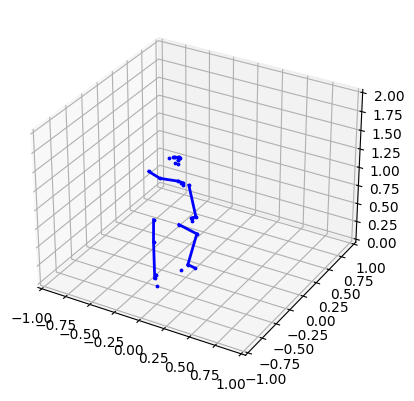

In [5]:
''' visualize dance motion data '''

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

key = dataloader.keys[0]
keypoints3d_list = dataloader.load_keypoints3d(key)

def animate(i):
    ax.cla()
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(0,2)

    keypoints3d = keypoints3d_list[i]
    for x, y, z in keypoints3d:
        ax.scatter(x, z, y, s=3, color='blue')

    for k in SKELETON_INFO.keys():
        x1, y1, z1 = keypoints3d[KEYPOINTS_DICT[SKELETON_INFO[k][0]]]
        x2, y2, z2 = keypoints3d[KEYPOINTS_DICT[SKELETON_INFO[k][1]]]
        ax.plot([x1,x2], [z1,z2], [y1,y2], lw=2, color='blue')

    return ax

anim = animation.FuncAnimation(fig, animate, frames=range(600, 780, 6), interval=int(1000/10), blit=False)
rc('animation', html='jshtml')
anim

In [6]:
dataloader.data

ID Dancer      Date            DataPath  Grade  IsReference  \
0   20221201     d0  20221213   d0_20221213_1.pkl      0         True   
1   20221202     d0  20221213   d0_20221213_2.pkl      0         True   
2   20230501     d0  20230528   d0_20230528_1.pkl      0         True   
3   20230502     d0  20230528   d0_20230528_2.pkl      0         True   
4   20221203     d1  20221213   d1_20221213_1.pkl      1        False   
5   20221204     d1  20221213   d1_20221213_2.pkl      1        False   
6   20221205     d2  20221213   d2_20221213_1.pkl      1        False   
7   20221206     d2  20221213   d2_20221213_2.pkl      1        False   
8   20221207     d3  20221213   d3_20221213_1.pkl      1        False   
9   20221208     d3  20221213   d3_20221213_2.pkl      1        False   
12  20221211     d5  20221213   d5_20221213_1.pkl      2        False   
13  20221212     d5  20221213   d5_20221213_2.pkl      2        False   
14  20221213     d6  20221213   d6_20221213_1.pkl      3        False   
15  20221214     d6  20221213   d6_20221213_2.pkl      3        False   
16  20221215     d7  20221213   d7_20221213_1.pkl      3        False   
17  20221216     d7  20221213   d7_20221213_2.pkl      3        False   
18  20221217     d8  20221213   d8_20221213_1.pkl      3        False   
19  20221218     d8  20221213   d8_20221213_2.pkl      3        False   
20  20230503     d9  20230528   d9_20230528_1.pkl      1        False   
21  20230504     d9  20230528   d9_20230528_2.pkl      1        False   
24  20230507    d11  20230528  d11_20230528_1.pkl      1        False   
25  20230508    d11  20230528  d11_20230528_2.pkl      1        False   
26  20230509    d12  20230528  d12_20230528_1.pkl      1        False   
27  20230510    d12  20230528  d12_20230528_2.pkl      1        False   
28  20230511    d13  20230528  d13_20230528_1.pkl      2        False   
29  20230512    d13  20230528  d13_20230528_2.pkl      2        False   
30  20230513    d14  20230528  d14_20230528_1.pkl      2        False   
31  20230514    d14  20230528  d14_20230528_2.pkl      2        False   
32  20230515     d2  20230528   d2_20230528_1.pkl      2        False   
33  20230516     d2  20230528   d2_20230528_2.pkl      2        False   
34  20230517    d15  20230528  d15_20230528_1.pkl      2        False   
35  20230518    d15  20230528  d15_20230528_2.pkl      2        False   
36  20230519     d7  20230528   d7_20230528_1.pkl      3        False   
37  20230520     d7  20230528   d7_20230528_2.pkl      3        False   
38  20230521    d16  20230528  d16_20230528_1.pkl      3        False   
39  20230522    d16  20230528  d16_20230528_2.pkl      3        False   
40  20230523    d17  20230528  d17_20230528_1.pkl      4        False   
41  20230524    d17  20230528  d17_20230528_2.pkl      4        False   
42  20230525    d18  20230528  d18_20230528_1.pkl      4        False   
43  20230526    d18  20230528  d18_20230528_2.pkl      4        False   

    Annotated  Dynamics  Sharpness  Scalability  Timing  Accuracy  Stability  
0       False        -1         -1           -1      -1        -1         -1  
1       False        -1         -1           -1      -1        -1         -1  
2       False        -1         -1           -1      -1        -1         -1  
3       False        -1         -1           -1      -1        -1         -1  
4        True         4          5            4       4         3          4  
5       False        -1         -1           -1      -1        -1         -1  
6        True         5          5            5       5         4          4  
7       False        -1         -1           -1      -1        -1         -1  
8        True         3          3            3       1         2          1  
9       False        -1         -1           -1      -1        -1         -1  
12       True         6          6            5       8         4          6  
13      False        -1         -1           -1      -1        -1   

Text(0, 0.5, 'Amount')

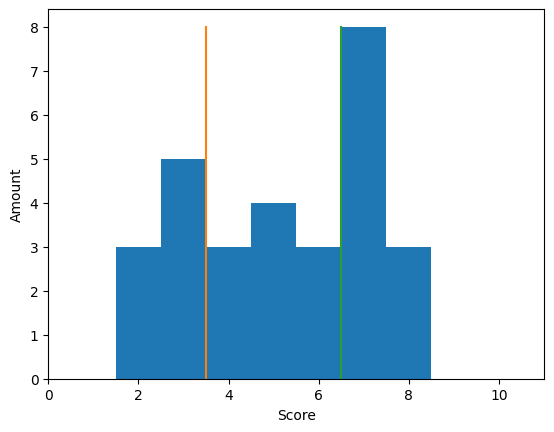

In [7]:
item = 'Dynamics'
num_classes = 3

''' determine category '''

data = dataloader.data
scores = data[item][data['IsReference'] | data['Annotated']].to_list()
filtered_scores = [score for score in scores if score >= 0]
counts = np.bincount(filtered_scores)
splits, label_transform = determine_split(counts, num_classes)


plt.figure()
plt.hist(scores, bins=10, range=(0.5,10.5))
for x in splits:
    plt.plot([x-0.5, x-0.5],[0, max(counts)])
plt.xlabel("Score")
plt.ylabel("Amount")

In [10]:
''' determine train test split '''

train_keys, test_keys = train_test_split(data, item, splits)
reference_keys = data['ID'][data['IsReference']].to_list()

# split dance motion by beat
frame_splits = get_frame_splits(bpm=161, fps=60, offset=9.9, n_beats=4, step=4, size=8)

# check test keys
data[data['ID'].isin(test_keys)]

ID Dancer      Date            DataPath  Grade  IsReference  \
24  20230507    d11  20230528  d11_20230528_1.pkl      1        False   
25  20230508    d11  20230528  d11_20230528_2.pkl      1        False   
34  20230517    d15  20230528  d15_20230528_1.pkl      2        False   
35  20230518    d15  20230528  d15_20230528_2.pkl      2        False   
42  20230525    d18  20230528  d18_20230528_1.pkl      4        False   
43  20230526    d18  20230528  d18_20230528_2.pkl      4        False   

    Annotated  Dynamics  Sharpness  Scalability  Timing  Accuracy  Stability  
24       True         3          3            2       3         2          3  
25       True         3          3            3       1         1          2  
34       True         5          5            6       6         4          6  
35       True         5          5            6       5         5          6  
42       True         7          8            5       5         7          6  
43       True         8          8            8       6         7          6

## Models

In [11]:
# create encoder
input_dim = 258
hidden_dim = 512
output_dim = 128
num_lstm_layers = 1
bidirectional = False
return_sequences = False
dropout_rate = 0.1

encoder = create_lstm_encoder(input_dim, hidden_dim, output_dim, num_lstm_layers, bidirectional, return_sequences, dropout_rate)
encoder.summary()

Model: "lstm_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 258)]       0         
                                                                 
 lstm (LSTM)                 (None, 512)               1579008   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
Total params: 1,644,672
Trainable params: 1,644,672
Non-trainable params: 0
_________________________________________________________________


## Train Encoder

In [14]:
num_embeddings = 128
learning_rate = 2*1e-3
epochs = 100

# add head
embedding_model = create_embedding_model(encoder, embedding_dim=num_embeddings)

# model for contrastive learning
triplet_model = create_triplet_model(embedding_model)

triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True),
    loss=triplet_loss,
    metrics=[swap_error],
)

triplet_model.summary()

Model: "triplet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, 258)]  0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, None, 258)]  0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 258)]  0           []                               
                                                                                                  
 embedding_model (Functional)   (None, 128)          1661184     ['input_8[0][0]',                
                                                                  'input_9[0][0]',    

In [15]:
# training model
train_generator = DataGenerator(dataloader, train_keys, reference_keys, frame_splits, item, label_transform, method='triplet')
valid_generator = DataGenerator(dataloader, test_keys, reference_keys, frame_splits, item, label_transform, method='triplet')

history = triplet_model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=16, shuffle=True)

Epoch 1/100
41/41 [==============================] - 23s 303ms/step - loss: 0.1721 - swap_error: 0.3140 - val_loss: 0.1728 - val_swap_error: 0.1250
Epoch 2/100
41/41 [==============================] - 10s 247ms/step - loss: 0.1582 - swap_error: 0.3018 - val_loss: 0.1308 - val_swap_error: 0.0208
Epoch 3/100
41/41 [==============================] - 10s 250ms/step - loss: 0.1571 - swap_error: 0.2973 - val_loss: 0.0913 - val_swap_error: 0.0625
Epoch 4/100
41/41 [==============================] - 10s 248ms/step - loss: 0.1287 - swap_error: 0.2759 - val_loss: 0.0640 - val_swap_error: 0.0625
Epoch 5/100
41/41 [==============================] - 11s 277ms/step - loss: 0.1160 - swap_error: 0.2393 - val_loss: 0.0781 - val_swap_error: 0.1042
Epoch 6/100
41/41 [==============================] - 9s 230ms/step - loss: 0.1047 - swap_error: 0.1951 - val_loss: 0.0684 - val_swap_error: 0.0417
Epoch 7/100
41/41 [==============================] - 10s 243ms/step - loss: 0.1076 - swap_error: 0.1905 - val_los

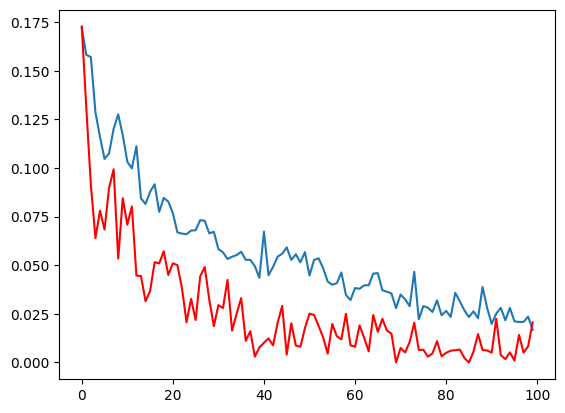

In [16]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', color='red')

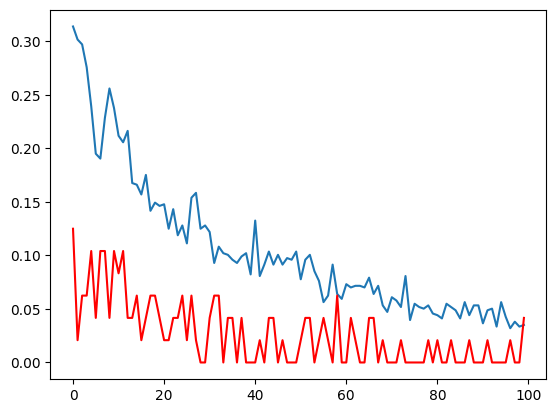

In [17]:
plt.figure()
plt.plot(history.history['swap_error'])
plt.plot(history.history['val_swap_error'], color='red')

21/21 [==============================] - 1s 8ms/step


<ipython-input-18-02d5cbf72298>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 12)


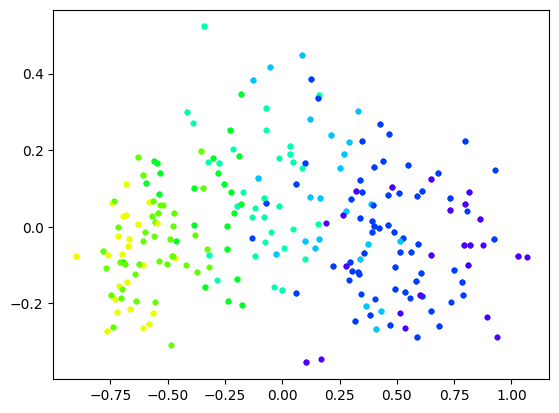

In [18]:
X = []
Y = []
for key in train_keys:
    for (start_frame, end_frame) in frame_splits:
        keypoints3d_list = dataloader.load_keypoints3d(key, start_frame, end_frame)
        features = extract_features(keypoints3d_list)
        score = dataloader.load_score(key, item)
        X.append(features)
        Y.append(score)

X = np.array(X)
Y = np.array(Y)

y_pred = encoder.predict(X)

# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(y_pred)
embeddings = pca.transform(y_pred)

# visualization
cmap = plt.cm.get_cmap("hsv", 12)
colors = cmap(np.arange(11))
plt.figure()
for embedding, y in zip(embeddings, Y):
    plt.scatter(embedding[0], embedding[1], color=colors[y], s=10)

## Train Evaluation Model

In [19]:
# for default model
#train_generator = DataGenerator(dataloader, train_keys, reference_keys, frame_splits, item, label_transform, method='default')
#valid_generator = DataGenerator(dataloader, test_keys, reference_keys, frame_splits, item, label_transform, method='default')
#
#model = create_model(encoder, input_dim=258, hidden_dims=[16,8], output_dim=num_classes, activation='softmax', dropout_rate=0.1, trainable=False)

# for reference model
train_generator = DataGenerator(dataloader, train_keys, reference_keys, frame_splits, item, label_transform, method='reference')
valid_generator = DataGenerator(dataloader, test_keys, reference_keys, frame_splits, item, label_transform, method='reference')

model = create_reference_model(encoder, hidden_dims=[128,64], output_dim=num_classes, activation='softmax', diff='sub', dropout_rate=0.1, trainable=False)


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate, amsgrad=True),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)
model.summary()

Model: "Reference-guided"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, 258)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 258)]  0           []                               
                                                                                                  
 lstm_encoder (Functional)      (None, 128)          1644672     ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 subtract (Subtract)            (None, 128)          0           ['lstm_encoder[0][

In [20]:
checkpoint_filepath = './checkpoints/best_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_categorical_accuracy', mode='max', save_best_only=True)

history = model.fit(train_generator, validation_data = valid_generator, epochs=epochs, batch_size=16, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 0.9585 - categorical_accuracy: 0.5833

41/41 [==============================] - 18s 343ms/step - loss: 0.9585 - categorical_accuracy: 0.5833 - val_loss: 0.7320 - val_categorical_accuracy: 0.7500
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.6670 - categorical_accuracy: 0.7037

41/41 [==============================] - 13s 322ms/step - loss: 0.6670 - categorical_accuracy: 0.7037 - val_loss: 0.5876 - val_categorical_accuracy: 0.8125
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.6051 - categorical_accuracy: 0.7130

41/41 [==============================] - 13s 312ms/step - loss: 0.6051 - categorical_accuracy: 0.7130 - val_loss: 0.4430 - val_categorical_accuracy: 0.8750
Epoch 4/100
41/41 [==============================] - 7s 171ms/step - loss: 0.5286 - categorical_accuracy: 0.7701 - val_loss: 0.5361 - val_categorical_accuracy: 0.7083
Epoch 5/100
41/41 [==============================] - 6s 143ms/step - loss: 0.5773 - categorical_accuracy: 0.7299 - val_loss: 0.4764 - val_categorical_accuracy: 0.7917
Epoch 6/100
41/41 [==============================] - 7s 173ms/step - loss: 0.5341 - categorical_accuracy: 0.7423 - val_loss: 0.5436 - val_categorical_accuracy: 0.7917
Epoch 7/100
41/41 [==============================] - 6s 143ms/step - loss: 0.5786 - categorical_accuracy: 0.7299 - val_loss: 0.3634 - val_categorical_accuracy: 0.8542
Epoch 8/100
41/41 [==============================] - 7s 170ms/step - loss: 0.5318 - categorical_accuracy: 0.7423 - val_loss: 0.6394 - val_categorical_accuracy: 0.7292
Epoch 9/1

41/41 [==============================] - 13s 312ms/step - loss: 0.5022 - categorical_accuracy: 0.7577 - val_loss: 0.3034 - val_categorical_accuracy: 0.9167
Epoch 14/100
41/41 [==============================] - 6s 142ms/step - loss: 0.5083 - categorical_accuracy: 0.7654 - val_loss: 0.3676 - val_categorical_accuracy: 0.8750
Epoch 15/100
41/41 [==============================] - 7s 168ms/step - loss: 0.4731 - categorical_accuracy: 0.7793 - val_loss: 0.4151 - val_categorical_accuracy: 0.8125
Epoch 16/100
41/41 [==============================] - 6s 140ms/step - loss: 0.5386 - categorical_accuracy: 0.7562 - val_loss: 0.4651 - val_categorical_accuracy: 0.7292
Epoch 17/100
41/41 [==============================] - 7s 167ms/step - loss: 0.4828 - categorical_accuracy: 0.7716 - val_loss: 0.3982 - val_categorical_accuracy: 0.8125
Epoch 18/100
41/41 [==============================] - 6s 145ms/step - loss: 0.5208 - categorical_accuracy: 0.7577 - val_loss: 0.4302 - val_categorical_accuracy: 0.7708
Epoc

41/41 [==============================] - 13s 311ms/step - loss: 0.4947 - categorical_accuracy: 0.7577 - val_loss: 0.2617 - val_categorical_accuracy: 0.9375
Epoch 35/100
41/41 [==============================] - 7s 170ms/step - loss: 0.4867 - categorical_accuracy: 0.7840 - val_loss: 0.3691 - val_categorical_accuracy: 0.8750
Epoch 36/100
41/41 [==============================] - 6s 141ms/step - loss: 0.4949 - categorical_accuracy: 0.7670 - val_loss: 0.4544 - val_categorical_accuracy: 0.8333
Epoch 37/100
41/41 [==============================] - 7s 170ms/step - loss: 0.4797 - categorical_accuracy: 0.7809 - val_loss: 0.4647 - val_categorical_accuracy: 0.8750
Epoch 38/100
41/41 [==============================] - 6s 140ms/step - loss: 0.4699 - categorical_accuracy: 0.7932 - val_loss: 0.4284 - val_categorical_accuracy: 0.8542
Epoch 39/100
41/41 [==============================] - 6s 142ms/step - loss: 0.4848 - categorical_accuracy: 0.7855 - val_loss: 0.4300 - val_categorical_accuracy: 0.8125
Epoc

41/41 [==============================] - 13s 327ms/step - loss: 0.4895 - categorical_accuracy: 0.7716 - val_loss: 0.2424 - val_categorical_accuracy: 0.9583
Epoch 66/100
41/41 [==============================] - 7s 170ms/step - loss: 0.4646 - categorical_accuracy: 0.7840 - val_loss: 0.2913 - val_categorical_accuracy: 0.9167
Epoch 67/100
41/41 [==============================] - 6s 142ms/step - loss: 0.4667 - categorical_accuracy: 0.7716 - val_loss: 0.4198 - val_categorical_accuracy: 0.8333
Epoch 68/100
41/41 [==============================] - 7s 168ms/step - loss: 0.4765 - categorical_accuracy: 0.7793 - val_loss: 0.3029 - val_categorical_accuracy: 0.8958
Epoch 69/100
41/41 [==============================] - 6s 140ms/step - loss: 0.4629 - categorical_accuracy: 0.7793 - val_loss: 0.2847 - val_categorical_accuracy: 0.8542
Epoch 70/100
41/41 [==============================] - 7s 170ms/step - loss: 0.4644 - categorical_accuracy: 0.7870 - val_loss: 0.3602 - val_categorical_accuracy: 0.8542
Epoc

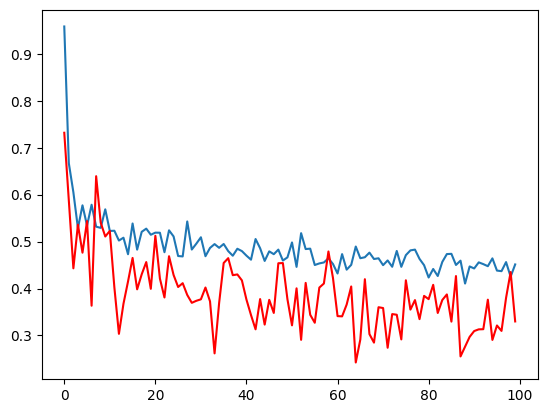

In [21]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', color='red')

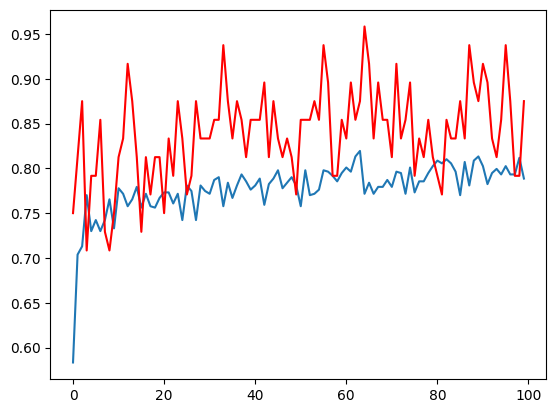

In [22]:
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history[f'val_categorical_accuracy'], label=f'val_categorical_accuracy', color='red')

2/2 [==============================] - 1s 19ms/step


<Axes: >

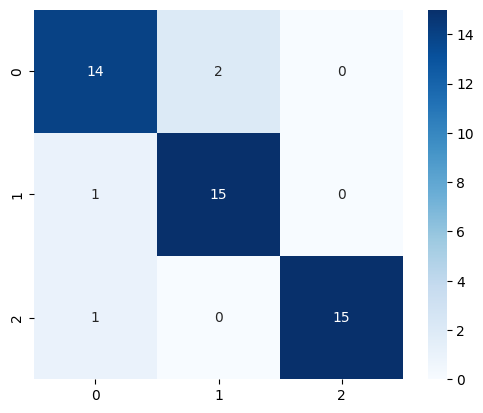

In [23]:
best_model = load_model(checkpoint_filepath)

batch_info = [valid_generator.info[i] for i in valid_generator.indexes]
X_test, Y_test =  valid_generator.get_reference_data(batch_info)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(Y_test, axis=-1)

plt.figure()
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')

In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.88      0.94      0.91        16
           2       1.00      0.94      0.97        16

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

